# Chapter IV: Improving Training of PINNs

This notebook covers techniques to improve the training of Physics-Informed Neural Networks (PINNs).

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])
import pickle
import copy

results_folder = '../results/IV_ImprovingPINNs'
from examples import allen_cahn

# --- Figure settings ---
save_fig = True
if save_fig:
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'

title_font_size = 8
axes_font_size = 6
page_width = 4.72441 # 120mm in inches
plotting_factor = 3

plt.style.use(['science', 'grid'])

plt.rcParams.update({
    "font.size": axes_font_size,
    "figure.titlesize": title_font_size,
    "axes.titlesize": title_font_size,
    "lines.linewidth": 2/plotting_factor,    # plot lines
    "lines.markersize": 4/plotting_factor,      # markers
    "axes.linewidth": 0.8/plotting_factor,      # axes border
    "xtick.major.width": 0.8/plotting_factor,   # x tick width
    "ytick.major.width": 0.8/plotting_factor,   # y tick width
    "xtick.minor.width": 0.6/plotting_factor,   # x minor tick width
    "ytick.minor.width": 0.6/plotting_factor,   # y minor tick width
    "xtick.major.size": 3.5/plotting_factor,    # x tick length
    "ytick.major.size": 3.5/plotting_factor,    # y tick length
    "xtick.minor.size": 2/plotting_factor,      # x minor tick length
    "ytick.minor.size": 2/plotting_factor,      # y minor tick length
    "grid.linewidth": 0.6/plotting_factor,      # grid lines
})

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

Enable just-in-time compilation with XLA.



## IV_2: Fourier Feature Embedding

Fourier features help in learning high-frequency components.

### 1-Run/load model

In [4]:
config_to_run_FF = []#["pinn", "spinn", "spinn_mod"]
results_file = os.path.join(results_folder, 'IV_2_FourierFeatures.pkl')

base_config_FF = {
    "fourier_features": False,
    "n_fourier_features": 128,
    "sigma": 10,
    "net_type": "PINN",
    "mlp_type": "mlp",
    "activations": "sin",
    "n_domain": 150**2,
    "lr": 1e-5,
    "lr_decay": ["warmup cosine", 1e-5, 1e-3, 1000, 100000, 1e-5], # cosine decay:init lr, peak lr, warmup iters, total iters, min lr
    "n_iter": 100000, 
    "rank": 32,
    "seed": 0,
}

all_config_FF = {
    "pinn": {**copy.deepcopy(base_config_FF), "n_fourier_features": 256},
    "spinn": {**copy.deepcopy(base_config_FF), "net_type": "SPINN" },
    "spinn_mod": {**copy.deepcopy(base_config_FF), "net_type": "SPINN", "mlp_type": "mlp_mod", "n_fourier_features": 64},
}

all_config_names_FF = list(all_config_FF.keys())

all_data_FF = {}
all_models_FF = {}
try:
    with open(results_file, 'rb') as f:
        saved_results = pickle.load(f)
except Exception:
    saved_results = {}

for config_name in config_to_run_FF:
    config_FF = all_config_FF[config_name]
    
    # Train SPINN with and without Fourier features
    print(f"Running configuration: {config_name}")
    all_data_FF[config_name] = allen_cahn.train(config_FF)
    print(f"Running configuration: {config_name} with Fourier Features")
    all_data_FF[config_name + "_FF"] = allen_cahn.train({**config_FF, "fourier_features": True})

    # Extract models
    all_models_FF[config_name] = all_data_FF[config_name].pop('model')
    all_models_FF[config_name + "_FF"] = all_data_FF[config_name + "_FF"].pop('model')

    # Update saved results dict
    saved_results.update({
        config_name: {**all_data_FF[config_name], "model_params": all_models_FF[config_name].net.params},
        config_name + "_FF": {**all_data_FF[config_name + "_FF"], "model_params": all_models_FF[config_name + "_FF"].net.params}
    })

# Save updated results back
with open(results_file, 'wb') as f:
    pickle.dump(saved_results, f)


restore_models = False  # Whether to reconstruct the models from saved params

# Load saved results if not all configs were run
if len(config_to_run_FF) < len(all_config_names_FF):
    try:
        with open(results_file, 'rb') as f:
            saved = pickle.load(f)
    except Exception:
        saved = {}
    
    for config_name in all_config_names_FF:
        if config_name in config_to_run_FF:
            continue
        for suffix in ("", "_FF"):
            key = config_name + suffix
            if key not in saved:
                print(f"Warning: {key} not found in saved results.")
                continue
            print(f"Loading saved results for: {key}")
            data = saved[key]
            all_data_FF[key] = {k: v for k, v in data.items() if k != "model_params"}
            if "model_params" in data:
                all_models_FF[key] = data["model_params"]

            if restore_models and "model_params" in data and "config" in data:
                try:
                    all_models_FF[key] = allen_cahn.train({
                        **data["config"],
                        "lr": 1e-3,
                        "n_iter": 0,
                        "restored_params": data["model_params"],
                    })["model"]
                except Exception:
                    pass

Loading saved results for: pinn
Loading saved results for: pinn_FF
Loading saved results for: spinn
Loading saved results for: spinn_FF
Loading saved results for: spinn_mod
Loading saved results for: spinn_mod_FF


### 2-Plot results

Fig width: 10.5, set it to 3.50 < 6.34 (A4 with margins) in latex to have a printed font size of 6.00 for titles and 5.00 for the axis


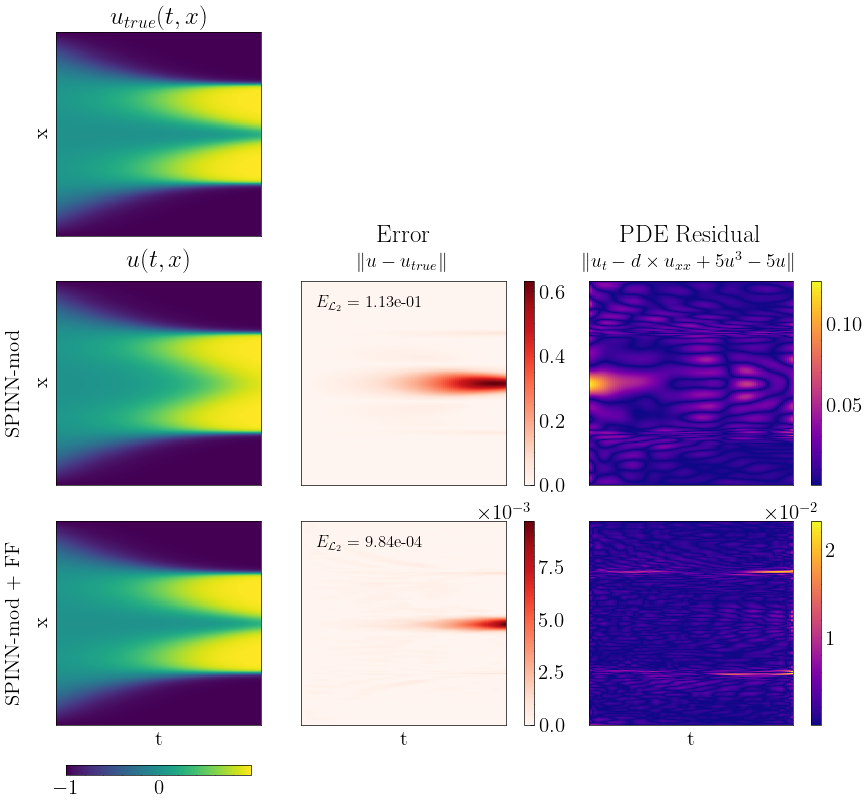

In [6]:
import matplotlib.transforms as mtransforms
from matplotlib import ticker

# --- Font size for printing ---
plotting_factor = 3
font_factor = 3
title_font_size = 6
axes_font_size = 5
plt.rcParams.update({
    "font.size": axes_font_size*font_factor,
    "figure.titlesize": title_font_size*font_factor,
    "axes.titlesize": title_font_size*font_factor,
})


config_to_plot_FF = ["pinn", "spinn", "spinn_mod"][2:3]
config_text_dict = {
    "pinn": "PINN",
    "pinn_FF": "PINN + FF",
    "spinn": "SPINN",
    "spinn_FF": "SPINN + FF",
    "spinn_mod": "SPINN-mod",
    "spinn_mod_FF": "SPINN-mod + FF",
}
X, y, xx, tt, u_true = allen_cahn.test_data(all_config_FF[config_to_plot_FF[0]])
    
u_pred_all, u_diff_all, pde_loss_all, rows_title = [], [], [], []

def fields_from_config(config, all_data, config_text_dict=config_text_dict):
    u_pred_all, u_diff_all, pde_loss_all, rows_title = [], [], [], []
    for key in config:
        if key not in all_data: 
            continue
        e = all_data[key]["evaluation"]
        u_true = e["u_true"]
        u_pred_all.append(e["u_pred"])
        u_diff_all.append(e["u_pred"] - u_true)
        pde_loss_all.append(e["pde_loss"])
        rows_title.append((e.get("l2_error", 1e9), config_text_dict[key]))

    order = sorted(range(len(rows_title)), key=lambda i: rows_title[i][0], reverse=True)
    u_pred_all = [u_pred_all[i] for i in order]
    u_diff_all = [u_diff_all[i] for i in order]
    pde_loss_all = [pde_loss_all[i] for i in order]
    rows_title = [rows_title[i][1] for i in order]
    u_pred_all = [u_true] + u_pred_all
    return u_pred_all, u_diff_all, pde_loss_all, rows_title

config_to_plot_FF_and_suffix = [c + suffix for c in config_to_plot_FF for suffix in ("", "_FF")]
u_pred_all, u_diff_all, pde_loss_all, rows_title = fields_from_config(config_to_plot_FF_and_suffix, all_data_FF)
n_rows = len(rows_title) 

fields_FF = {
    "Solution": {
        "data": u_pred_all,
        "title": r"$u(t,x)$",
        "cmap": "viridis",
        "abs": False,
    },
    "Error": {
        "data": u_diff_all,
        "title": "Error\n" + r"\fontsize{14}{14} $\|u - u_{true}\|$",
        "cmap": "Reds",
        "abs": True,
    },
    "PDE Residual": {
        "data": pde_loss_all,
        "title": "PDE Residual\n" + r"\fontsize{14}{14}$\|u_t - d \times u_{xx} + 5u^3 - 5u\|$",
        "cmap": "plasma",
        "abs": True,
    },
}

fig, ax = plt.subplots(1+n_rows,3, figsize=(10.5,(1+n_rows)*3))

allen_cahn.plot_results(fig, ax, fields_FF, tt, xx, rows_title, font_factor, title_font_size, axes_font_size)

plt.show()

# save figure
figure_folder = os.path.join(results_folder, "IV_2_FourierFeatures_Figures")
os.makedirs(figure_folder, exist_ok=True)
figure_name = "+".join(config_to_plot_FF) + ".png"
fig.savefig(os.path.join(figure_folder, figure_name), bbox_inches='tight', dpi=300)

In [7]:
import pandas as pd
from IPython.display import display

#table of all results
# build a summary dataframe from all_data_FF
def build_results_df(all_data, config_text_dict=None, append_config=False):
    rows = []
    for key in sorted(all_data.keys()):
        entry = all_data[key]
        evaluation = entry.get("evaluation", {})
        l2 = evaluation.get("l2_error", np.nan)
        mean_pde = evaluation.get("mean_pde_residual", np.nan)
        iters_per_s = entry.get("iterations_per_sec", np.nan)
        elapsed = entry.get("elapsed_time", np.nan)
        name = config_text_dict.get(key, key) if config_text_dict is not None else key

        rows.append({
            "model_name": name,
            "l2_error": float(l2) if np.isfinite(l2) else np.nan,
            "mean_pde_residual": float(mean_pde) if np.isfinite(mean_pde) else np.nan,
            "iterations_per_sec": float(iters_per_s) if np.isfinite(iters_per_s) else np.nan,
            "elapsed_time_min": float(elapsed)/60 if np.isfinite(elapsed) else np.nan,
        })

        if append_config:
            config = entry.get("config", {})
            for k, v in config.items():
                if k not in rows[-1]:
                    rows[-1][k] = v

    df = pd.DataFrame(rows)
    # sort by l2 error (descending as in original)
    df = df.sort_values("l2_error", ascending=False).reset_index(drop=True)
    return df

# Build dataframe from all_data_FF
append_config = False
df_results = build_results_df(all_data_FF, config_text_dict=config_text_dict, append_config=append_config)
# convert elapsed time from seconds to minutes and display

display(
    df_results.style
    .background_gradient(subset=["l2_error"], cmap="Greens_r")
    .format("{:.2e}", subset=["l2_error", "mean_pde_residual"])
    .format("{:.2f}", subset=["iterations_per_sec"])
    .format("{:.2f}", subset=["elapsed_time_min"])
    .set_properties(subset=["model_name"], **{"text-align": "left"})
)

# Save dataframe to latex
# latex_folder = os.path.join(results_folder, "IV_2_FourierFeatures_Tables")
# os.makedirs(latex_folder, exist_ok=True)
# table_name = "one_run_config.tex" if append_config else "one_run.tex"
# latex_file = os.path.join(latex_folder, table_name)
# with open(latex_file, 'w') as f:
#     f.write(df_results.to_latex(index=False, float_format="%.2e", column_format="lcccc", longtable=False))

,model_name,l2_error,mean_pde_residual,iterations_per_sec,elapsed_time_min
0,SPINN,9.14e-01,1.07e-01,538.36,0.93
1,PINN,2.23e-01,3.55e-02,1031.73,0.97
2,SPINN-mod,1.13e-01,1.22e-02,370.86,2.70
3,SPINN + FF,1.68e-02,3.17e-03,598.68,0.84
4,SPINN-mod + FF,9.84e-04,1.26e-03,419.91,2.38
5,PINN + FF,2.39e-04,9.10e-04,261.73,3.82


## IV_3: Self-Adaptive Attention

Self-adaptive attention mechanisms weight the PDE loss in some regions.

In [2]:
results_file = os.path.join(results_folder, 'IV_2_SelfAttention.pkl')
config_to_run_SA = []  # e.g. ["pinn_SA", "spinn_SA", "spinn_mod_SA", "weight_vis"]

# === Base configuration ===
base_config_SA = {
    "fourier_features": True,
    "n_fourier_features": 128,
    "sigma": 10,
    "net_type": "SPINN",
    "mlp_type": "mlp",
    "activations": "sin",
    "n_domain": 150**2,
    "lr": 1e-5,
    "lr_decay": ["warmup cosine", 1e-5,1e-3, 1000, 100000, 1e-5], # cosine decay: init lr, peak lr, warmup iters, total iters, min lr
    "n_iter": 100000, 
    "rank": 64,
    "seed": 0,
    "SA": True,
}

# === All model configs ===
all_config_SA = {
    "pinn_SA": {**base_config_SA, "net_type": "PINN", "n_fourier_features": 256},
    "spinn_SA": {**base_config_SA, "net_type": "SPINN"},
    "spinn_mod_SA": {**base_config_SA, "net_type": "SPINN", "mlp_type": "mlp_mod"},
    "weight_vis": {**base_config_SA,"lr": 1e-3,"lr_decay": ["warmup cosine",1e-3, 1e-3, 3000, 50000, 1e-5]}
}

all_config_names_SA = list(all_config_SA.keys())


iters_pde_w = [500, 2500, 47000]
all_data_SA, all_models_SA = {}, {}

# === Load existing results ===
try:
    with open(results_file, 'rb') as f:
        saved_results = pickle.load(f)
except Exception:
    saved_results = {}

# === Run or load each configuration ===
for config_name in config_to_run_SA:
    print(f"Running configuration: {config_name}")
    config_SA = all_config_SA[config_name]

    if config_name == "weight_vis":
        results_weight_vis = {}
        data_weight_vis = allen_cahn.train({**config_SA, "lr": 1e-3, "n_iter": 0})
        model = data_weight_vis.pop('model')

        for i, iter_ in enumerate(iters_pde_w):
            loss_history, _ = model.train(iter_)
            total_iter = sum(iters_pde_w[:i+1])
            results_weight_vis[total_iter] = allen_cahn.eval(config_SA, model)
            results_weight_vis[total_iter]["pde_weights"] = model.external_trainable_variables[0].value
            print(f"Iter {total_iter}: L2={results_weight_vis[total_iter]['l2_error']:.3e}, "
                  f"PDE={results_weight_vis[total_iter]['mean_pde_residual']:.3e}")

        all_models_SA[config_name] = model
        data = {**data_weight_vis, "evaluation": results_weight_vis}
        all_data_SA[config_name] = data

    else:
        data = allen_cahn.train(config_SA)
        all_models_SA[config_name] = data.pop('model')
        all_data_SA[config_name] = data

    saved_results[config_name] = {**data, "model_params": all_models_SA[config_name].net.params}

# Save updated results back
with open(results_file, 'wb') as f:
    pickle.dump(saved_results, f)


restore_models = False  # Whether to reconstruct the models from saved params

# Load saved results if not all configs were run
if len(config_to_run_SA) < len(all_config_names_SA):
    try:
        with open(results_file, 'rb') as f:
            saved = pickle.load(f)
    except Exception:
        saved = {}

    for config_name in all_config_names_SA:
        if config_name in config_to_run_SA:
            continue
        key = config_name
        if key not in saved:
            print(f"Warning: {key} not found in saved results.")
            continue
        print(f"Loading saved results for: {key}")
        data = saved[key]
        all_data_SA[key] = {k: v for k, v in data.items() if k != "model_params"}
        if "model_params" in data:
            all_models_SA[key] = data["model_params"]

        if restore_models and "model_params" in data and "config" in data:
            try:
                all_models_SA[key] = allen_cahn.train({
                    **data["config"],
                    "lr": 1e-3,
                    "n_iter": 0,
                    "restored_params": data["model_params"],
                })["model"]
            except Exception:
                pass


Loading saved results for: pinn_SA
Loading saved results for: spinn_SA
Loading saved results for: spinn_mod_SA
Loading saved results for: weight_vis


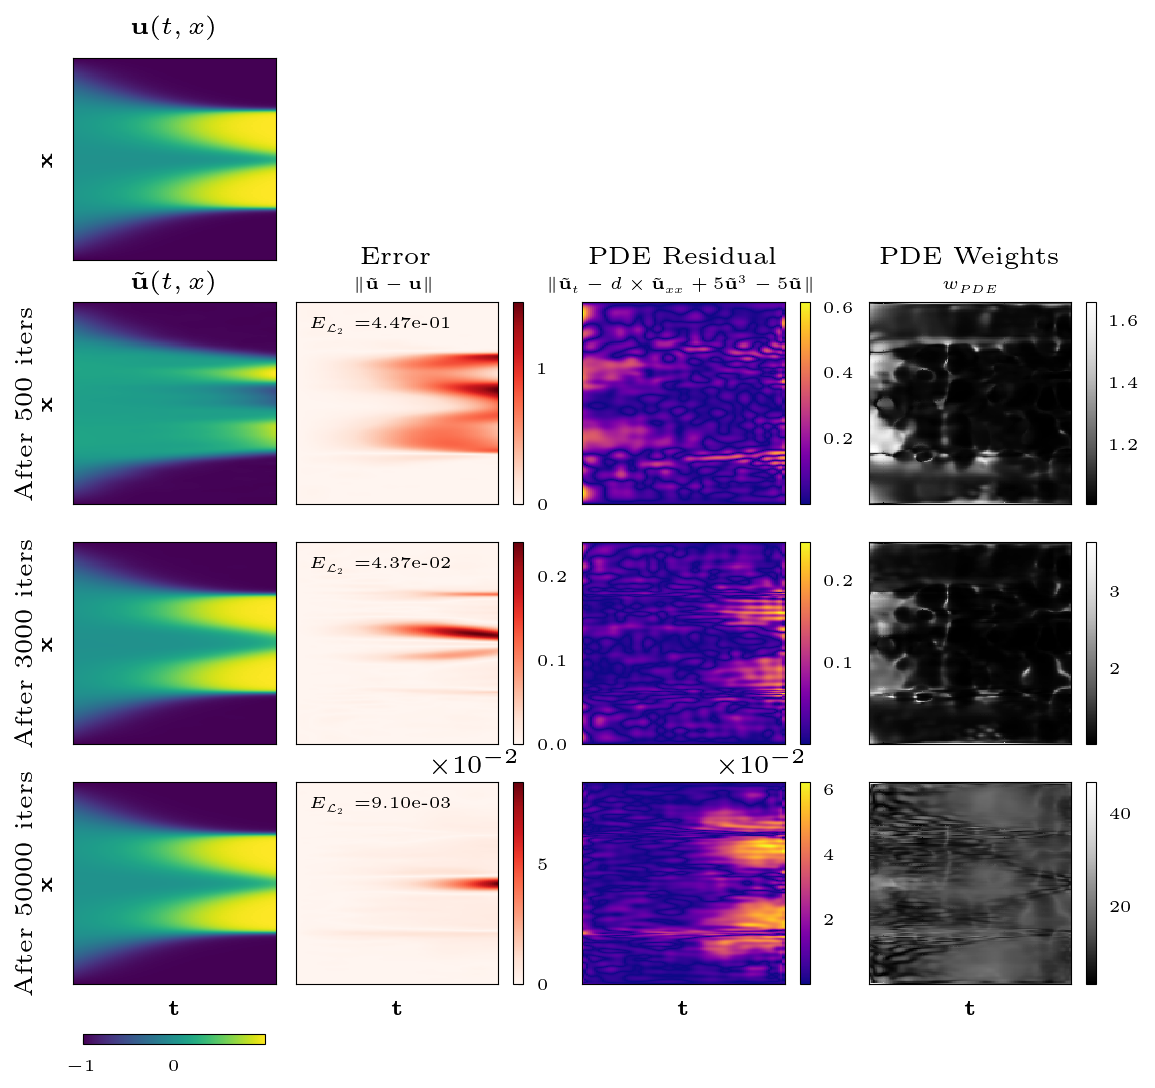

In [4]:
X, y, xx, tt, u_true = allen_cahn.test_data(base_config_SA)
X_train = [np.linspace(-1,1,150),np.linspace(0,1,150)] #all_models_SA["weight_vis"].data.train_x[0]
x_train, t_train = np.meshgrid(X_train[0], X_train[1])

# Plot evaluation at different PDE weight iterations using results_SA
u_pred_all, pde_loss_all, pde_weights_all = [], [], []
results_weight_vis = all_data_SA["weight_vis"]["results"]
for k in sorted(results_weight_vis.keys()):
    u_pred_all.append(results_weight_vis[k]["u_pred"])
    pde_loss_all.append(results_weight_vis[k]["pde_loss"])
    pde_weights_all.append(results_weight_vis[k]["pde_weights"].reshape(x_train.shape).T)

# Use ground truth from any entry (they are the same)
u_true = results_weight_vis[min(results_weight_vis.keys())]["u_true"]
u_diff_all = [u - u_true for u in u_pred_all]

rows_title = [f"After {k} iters" for k in sorted(results_weight_vis.keys())]

fields_SA_weight_vis = {
    "Solution": {
        "data": [u_true] + u_pred_all,
        "title": r"$\tilde{\mathbf{u}}(t,x)$",
        "cmap": None,
        "abs": False,
    },
    "Error": {
        "data": u_diff_all,
        "title": "Error\n" + r"\fontsize{4}{4} $\|\tilde{\mathbf{u}} - \mathbf{u}\|$",
        "cmap": "Reds",
        "abs": True,
    },
    "PDE Residual": {
        "data": pde_loss_all,
        "title": "PDE Residual\n" + r"\fontsize{4}{4}$\|\tilde{\mathbf{u}}_t - d \times \tilde{\mathbf{u}}_{xx} + 5\tilde{\mathbf{u}}^3 - 5\tilde{\mathbf{u}}\|$",
        "cmap": "plasma",
        "abs": True,
    },
    "PDE Weights": {
        "data": pde_weights_all,
        "title": "PDE Weights\n" + r"\fontsize{4}{4}$w_{PDE}$",
        "cmap": "Greys_r",
        "abs": False,
        "x_fields": x_train,
        "t_fields": t_train,
    },
}
fig, ax = plt.subplots(4,4, figsize=(page_width,0.85*page_width), dpi=300)
allen_cahn.plot_results(fig, ax, fields_SA_weight_vis, tt, xx, rows_title)
plt.show()

In [5]:
all_data_SA['weight_vis'].keys()

dict_keys(['config', 'elapsed_time', 'iterations_per_sec', 'losshistory', 'evaluation', 'results'])

Fig width: 10.5, set it to 3.50 < 6.34 (A4 with margins) in latex to have a printed font size of 6.00 for titles and 5.00 for the axis


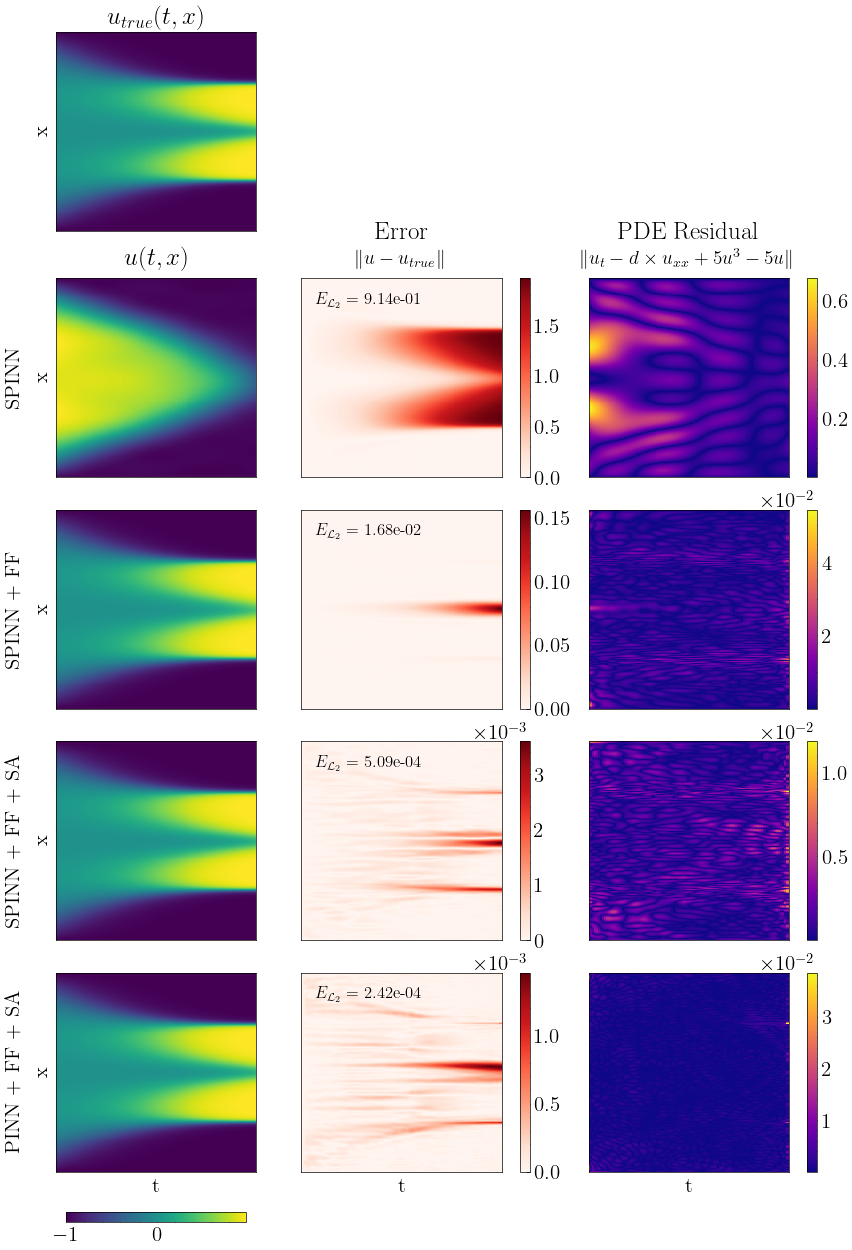

In [7]:
all_data_FF_SA = {**all_data_FF, **all_data_SA}
config_to_plot_FF_SA = ["spinn", "spinn_FF", "spinn_SA", "pinn_SA"]

config_text_dict_FF_SA = copy.deepcopy(config_text_dict)
config_text_dict_FF_SA.update({
    "pinn_SA": "PINN + FF + SA",
    "spinn_SA": "SPINN + FF + SA",
    "spinn_mod_SA": "SPINN-mod + FF + SA",
})

u_pred_all, u_diff_all, pde_loss_all, rows_title = fields_from_config(config_to_plot_FF_SA, all_data_FF_SA, config_text_dict_FF_SA)
n_rows = len(rows_title) 

fields_FF_SA = copy.deepcopy(fields_FF)
fields_FF_SA["Solution"]["data"] = u_pred_all
fields_FF_SA["Error"]["data"] = u_diff_all
fields_FF_SA["PDE Residual"]["data"] = pde_loss_all

fig, ax = plt.subplots(1+n_rows,3, figsize=(10.5,(1+n_rows)*3))

plot_allen_cahn_results(fig, ax, fields_FF_SA, tt, xx, rows_title)

In [8]:
# Build dataframe from all_data_FF
append_config = False
df_results = build_results_df(all_data_FF_SA, config_text_dict=config_text_dict_FF_SA, append_config=append_config)
# remove any "weight_vis" rows from the results table and reset index
df_results = df_results[~df_results["model_name"].astype(str).str.contains("weight_vis", case=False)].reset_index(drop=True)
# convert elapsed time from seconds to minutes and display

display(
    df_results.style
    .background_gradient(subset=["l2_error"], cmap="Greens_r")
    .format("{:.2e}", subset=["l2_error", "mean_pde_residual"])
    .format("{:.2f}", subset=["iterations_per_sec"])
    .format("{:.2f}", subset=["elapsed_time_min"])
    .set_properties(subset=["model_name"], **{"text-align": "left"})
)

# Save dataframe to latex
latex_folder = os.path.join(results_folder, "IV_2_SelfAttention_Tables")
os.makedirs(latex_folder, exist_ok=True)
table_name = "one_run_config.tex" if append_config else "one_run.tex"
latex_file = os.path.join(latex_folder, table_name)
with open(latex_file, 'w') as f:
    f.write(df_results.to_latex(index=False, float_format="%.2e", column_format="lcccc", longtable=False))

,model_name,l2_error,mean_pde_residual,iterations_per_sec,elapsed_time_min
0,SPINN,9.14e-01,1.07e-01,538.36,0.93
1,PINN,2.23e-01,3.55e-02,1031.73,0.97
2,SPINN-mod,1.13e-01,1.22e-02,370.86,2.70
3,SPINN + FF,1.68e-02,3.17e-03,598.68,0.84
4,SPINN-mod + FF + SA,1.67e-03,2.07e-03,367.68,3.63
5,SPINN-mod + FF,9.84e-04,1.26e-03,419.91,2.38
6,SPINN + FF + SA,5.09e-04,1.09e-03,284.13,4.69
7,PINN + FF + SA,2.42e-04,6.83e-04,270.55,4.93
8,PINN + FF,2.39e-04,9.10e-04,261.73,3.82


## IV_4: Hyperparameter Optimization with Wandb Sweeps

Use Wandb sweeps for systematic hyperparameter optimization. The sweep configurations below are based on the YAML files in `examples/allen_cahn/HPO/`.

In [ ]:
# === Wandb Sweep Configuration & Command Generator ===
import wandb, yaml, os, numpy as np

# Results storage - both for CSVs and wandb local files
sweep_results_folder = os.path.join(results_folder, 'Sweeps')
os.makedirs(sweep_results_folder, exist_ok=True)

# Set wandb local directory for this notebook session
os.environ['WANDB_DIR'] = sweep_results_folder
os.environ['WANDB_DATA_DIR'] = os.path.join(sweep_results_folder, "wandb_cache")

# === Sweep configurations ===
sweep_config_pinn = {
    'name': 'pinn_sweep',
    'program': 'allen_cahn_model.py',
    'method': 'grid',
    'metric': {'name': 'l2_relative_error', 'goal': 'minimize'},
    'parameters': {
        'net_type': {'value': 'PINN'},
        'n_fourier_features': {'values': [128, 256]},
        'activations': {'values': ['tanh', 'sin']},
        'n_domain': {'value': 22500},  # 150**2
        'n_iter': {'value': 100000},
        'seed': {'values': [0, 1, 2, 3]},
        'fourier_features': {'value': True},
        'lr': {'value': 1e-5},
        'lr_decay': {'values': [['warmup cosine', 1e-5,1e-3, 1000, 100000, 1e-5],
                                ['exponential', 1e-3, 2000, 0.9]]},
        'SA': {'values': [False,True]},
    }
}

sweep_config_spinn = {
    'name': 'spinn_sweep',
    'program': 'allen_cahn_model.py',
    'method': 'grid',
    'metric': {'name': 'l2_relative_error', 'goal': 'minimize'},
    'parameters': {
        'net_type': {'value': 'SPINN'},
        'n_fourier_features': {'values': [32, 64]},
        'activations': {'values': ['tanh', 'sin']},
        'n_domain': {'values': [22500]},  # 150**2 
        'mlp_type': {'values': ['mlp', 'modified-mlp']},
        'rank': {'values': [32, 64]},
        'seed': {'values': [0, 1, 2, 3]},
        'fourier_features': {'value': True},
        'n_iter': {'value': 100000},
        'lr': {'value': 1e-5},
        'lr_decay': {'values': [['cosine', 1e-3, 100000, 1e-5],
                                ['warmup cosine', 1e-5, 1e-3, 1000, 100000, 1e-5],
                                ['warmup exponential', 1e-5, 1e-3, 1000, 2000, 0.9]]},

        'SA': {'values': [False,True]},
    }
}

# === Sweep creation ===
SWEEP_TYPE = 'spinn'  # 'pinn' or 'spinn'
sweep_configs = {'pinn': sweep_config_pinn, 'spinn': sweep_config_spinn}
project_name = 'Allen-Cahn'

# Create sweep
sweep_config = sweep_configs[SWEEP_TYPE]
create_sweep = False
if create_sweep:
    sweep_id = wandb.sweep(sweep_config, project=project_name)
    print(f"✅ Created sweep: {sweep_id}")
else:
    existing_sweep = {"spinn":"fyzp6zoi", "pinn":"fyzp6zoi"}
    sweep_id = existing_sweep[SWEEP_TYPE]
    print(f"ℹ️ Using existing sweep: {sweep_id}")

# === Helper: count total runs ===
def count_combinations(cfg):
    return np.prod([len(p['values']) if 'values' in p else 1 for p in cfg['parameters'].values()])

n_runs = count_combinations(sweep_config)
print(f"📊 Expected number of runs: {n_runs}")

# === Generate CLI commands ===
entity = wandb.api.default_entity
sweep_dir_abs = os.path.abspath(sweep_results_folder)
wandb_cache_abs = os.path.join(sweep_dir_abs, "wandb_cache")

print("\n" + "="*70)
print("🚀 RUN IN TERMINAL:")
print("="*70)
print(f"cd {os.path.abspath('examples/allen_cahn')}")
print(f"conda activate jax")
print(f"export WANDB_DIR={sweep_dir_abs}")
print(f"export WANDB_DATA_DIR={wandb_cache_abs}")
print(f"wandb agent {entity}/{project_name}/{sweep_id}")
print("="*70)

ℹ️ Using existing sweep: fyzp6zoi
📊 Expected number of runs: 128

🚀 RUN IN TERMINAL:
cd /home/bonneted/PhD/examples/allen_cahn
conda activate jax
export WANDB_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch
export WANDB_DATA_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch/wandb_cache
wandb agent None/Allen-Cahn/fyzp6zoi

🚀 RUN IN TERMINAL:
cd /home/bonneted/PhD/examples/allen_cahn
conda activate jax
export WANDB_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch
export WANDB_DATA_DIR=/home/bonneted/PhD/results/IV_ImprovingTraining/HyperparameterSearch/wandb_cache
wandb agent None/Allen-Cahn/fyzp6zoi


In [5]:
import os, json, pandas as pd, wandb

LOAD_RUNS_FROM_WANDB = False
ENTITY, PROJECT = "damien-bonnet", "Allen-Cahn"
sweep_results_folder = os.path.join(results_folder, 'HyperparameterSearch')

def load_project_results(ENTITY, PROJECT):
    api = wandb.Api()
    runs = api.runs(f"{ENTITY}/{PROJECT}")

    unwrap = lambda v: v['value'] if isinstance(v, dict) and len(v) == 1 and 'value' in v else v

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary = {k: unwrap(v) for k, v in json.loads(run.summary._json_dict).items() if not k.startswith('_')}
        config = {k: unwrap(v) for k, v in json.loads(run.config).items() if not k.startswith('_')}
        summary_list.append(summary)
        config_list.append(config)
        name_list.append(run.name)

    # Flatten into single row per run
    runs_df = pd.DataFrame([
        {"run_name": name} | {k: v for k, v in config.items() if k not in summary} | summary
        for name, config, summary in zip(name_list, config_list, summary_list)
    ])
    print(f"Loaded {len(runs_df)} runs from wandb.")
    return runs_df


if LOAD_RUNS_FROM_WANDB:
    runs_df = load_project_results(ENTITY, PROJECT)
    # Save to CSV
    runs_df.to_csv(os.path.join(sweep_results_folder, f'AllRuns_{PROJECT}.csv'), index=False)
else:
    runs_df = pd.read_csv(os.path.join(sweep_results_folder, f'AllRuns_{PROJECT}.csv'))
    print(f"Loaded {len(runs_df)} runs from CSV.")

Loaded 841 runs from CSV.


In [7]:
# Display aggregated results 
cols = [c for c in ["net_type","mlp_type", "activations", "n_fourier_features", "lr_decay", "rank"] if c in runs_df]
#not considering 'n_domain' as both 150**2 and 200**2 yield exact same results

runs_df_clean = runs_df.copy()
runs_df_clean["lr_decay"] = runs_df_clean["lr_decay"].apply(lambda x: x.strip("['']").split("',")[0] if isinstance(x, str) else x)

mask = (runs_df_clean["mlp_type"] == "modified-mlp")
runs_df_clean.loc[mask, "activations"] = 'sin/tanh' # same results observed for both activations with modified-mlp
runs_df_clean["elapsed_time"] = runs_df_clean["elapsed_time_s"]/60

agg = (runs_df_clean.groupby(cols)
            .agg(mean_l2=("l2_relative_error","mean"),
                std_l2=("l2_relative_error","std"),
                min_l2=("l2_relative_error","min"),
                max_l2=("l2_relative_error","max"),
                elapsed_time=("elapsed_time","mean"),
                iter_per_sec=("iterations_per_sec","mean"),
                count=("l2_relative_error","count"))
            .reset_index()
            .sort_values("mean_l2"))

display(agg.style.background_gradient(cmap="Greens_r",subset=["mean_l2","min_l2","max_l2"])
                        .background_gradient(cmap="Reds",subset=["std_l2"])
                        .format("{:.2e}",subset=["mean_l2","std_l2","min_l2","max_l2"])
                        .format("{:.1f}",subset=["elapsed_time","iter_per_sec"]))


,net_type,mlp_type,activations,n_fourier_features,lr_decay,rank,mean_l2,std_l2,min_l2,max_l2,elapsed_time,iter_per_sec,count
3,PINN,mlp,sin,256,warmup cosine,64,2.33e-04,8.39e-05,1.70e-04,4.36e-04,4.7,283.5,8
7,PINN,mlp,tanh,256,warmup cosine,64,3.86e-04,1.40e-04,1.88e-04,6.53e-04,4.6,290.4,8
6,PINN,mlp,tanh,256,exponential,64,6.04e-04,2.99e-04,3.10e-04,1.23e-03,4.6,291.1,8
1,PINN,mlp,sin,128,warmup cosine,64,6.15e-04,2.32e-04,3.38e-04,9.79e-04,3.3,398.7,8
5,PINN,mlp,tanh,128,warmup cosine,64,6.82e-04,2.49e-04,3.15e-04,1.02e-03,3.3,407.3,8
51,SPINN,modified-mlp,sin/tanh,64,cosine,64,7.84e-04,3.62e-04,2.45e-04,1.22e-03,4.0,428.7,16
54,SPINN,modified-mlp,sin/tanh,64,warmup cosine,32,9.26e-04,8.26e-04,2.57e-04,3.09e-03,4.1,376.5,40
50,SPINN,modified-mlp,sin/tanh,64,cosine,32,9.90e-04,6.83e-04,3.15e-04,2.45e-03,4.2,420.7,16
2,PINN,mlp,sin,256,exponential,64,1.06e-03,4.87e-04,5.17e-04,2.02e-03,4.7,283.7,8
55,SPINN,modified-mlp,sin/tanh,64,warmup cosine,64,1.19e-03,6.16e-04,5.10e-04,2.55e-03,3.9,391.5,40
